# Written Response: Jupyter Notebook to Processing Pipeline

Gait analysis is the systematic study of animal locomotion through the measurement of body movements. To translate a Jupyter notebook containing a machine learning model for gait analysis into a software application, I will follow the following steps:

1. I will **extract the relevant code** from the notebook, including core components and functions such as model loading, data pre-processing, and accuracy predictions. I will convert this code into separate functions, classes, and modules in Python files to ensure reproducibility. Additionally, I will create a user-friendly interface, such as a **command-line interface**, to facilitate interaction with the software. This will enable users to easily upload images/videos, specify output paths, and configure parameters using command-line inputs. The argparse library can be utilized for this purpose.

2. I will **address data processing**. Depending on the input type, whether it's an image or video, I will implement code to handle both data formats. OpenCV offers numerous functions for processing images and videos. Furthermore, I will preprocess the input data to ensure they adhere to the desired format required by the machine learning model. Common practices include resizing and normalizing images or standardizing video lengths. Additionally, I will partition the data into training, validation, and test sets for subsequent steps.

3. I will **load pre-trained models and apply them to the input data**. Pre-trained models available online, trained on extensive datasets like ImageNet, can be leveraged to expedite training and potentially improve prediction accuracy. I will train the model on our training data, optimizing objective functions using training code. Validation sets will be utilized to prevent overfitting, while test sets will be used solely for model evaluation.

4. I will perform the **post-processing and visualization** in the fourth step. This may involve storing the model with the best performance for future use. 
Additionally, data visualizations, such as plotting sample input images alongside their prediction results, can be created. Attention maps for transformer-based models can be visualized, and heat maps can be used to identify important features. Documentation and usage instructions will also be written for the software product.

5. I will **deploy the machine learning pipeline** as a software product, employing DevOps techniques like AWS and Microsoft Azure. Once the software is complete, I will package it into a distributable format, such as a Python package or executable file, using tools like Docker. This will facilitate easy deployment and usage of the software.




# Demo: Vision Transformer for MNIST Image Classification 

### Mount on Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


### Imports

In [ ]:
import time
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms
print("Running on torch.__version__ = ", torch.__version__)

torch.backends.cudnn.deterministic = True

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

Running on torch.__version__ =  1.13.1+cu116


### Helper Functions

In [ ]:
# a function to move tensors from the CPU to the GPU and vice versa
def dict_to_device(orig, device):
    new = {}
    for k,v in orig.items():
        new[k] = v.to(device)
    return new

# a function to plot a batch of images together
def plot_images(img, ax):
    img = torchvision.utils.make_grid(img)
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))  

### Dataset and Dataloader

In [ ]:
# Use standard MNIST dataset
class MyDataset(torchvision.datasets.MNIST):    
    def __init__(self, *args, debug=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.debug = debug
    
    def __getitem__(self, idx):
        data = super().__getitem__(idx)
        img = data[0]
        digit = data[1]
        return {'image': img, 'digit': digit}
    
    def __len__(self):
        return super().__len__()

dataset = MyDataset(
    root = './',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),        
    ]),
    debug=True,
)

test_set = MyDataset(
    root = './',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),        
    ]),
    debug=True,
)

loader = torch.utils.data.DataLoader(dataset, batch_size=128, num_workers=0)

In [ ]:
# Define the dataloaders and split into train, validation, and test
size = len(dataset)
train_set, val_set = torch.utils.data.random_split(dataset, [int(size * 0.8), int(size * 0.2)])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=True, num_workers=0)

print('train_set:', len(train_set))
print('val_set:', len(val_set))
print('test_set:', len(test_set))

train_set: 48000
val_set: 12000
test_set: 10000


### ViT Network

A **Vision Transformer** that takes an image as input and classifies it into ten classes, digits 0 to 9.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
import math

# Source: https://github.com/UdbhavPrasad072300/Transformer-Implementations/blob/main/transformer_package/models/transformer.py

class MultiHeadAttention(nn.Module):

    def __init__(self, embed_size: int, num_heads: int, dropout: float = 0.2, batch_dim: int = 0):
        super(MultiHeadAttention, self).__init__()

        self.embed_size = embed_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.batch_dim = batch_dim

        self.dropout_layer = nn.Dropout(dropout)

        self.head_size = self.embed_size // self.num_heads

        self.Q = nn.Linear(self.embed_size, self.embed_size)
        self.K = nn.Linear(self.embed_size, self.embed_size)
        self.V = nn.Linear(self.embed_size, self.embed_size)

        self.linear = nn.Linear(self.embed_size, self.embed_size)

    def forward(self, q, k, v, mask=None):
        if self.batch_dim == 0:
            out = self.batch_0(q, k, v, mask)
        elif self.batch_dim == 1:
            out = self.batch_1(q, k, v, mask)

        return out

    def batch_0(self, q, k, v, mask=None):
        q_batch_size, q_seq_len, q_embed_size = q.size()
        k_batch_size, k_seq_len, k_embed_size = k.size()
        v_batch_size, v_seq_len, v_embed_size = v.size()

        q = self.Q(q).reshape(q_batch_size, q_seq_len, self.num_heads, self.head_size)
        k = self.K(k).reshape(k_batch_size, k_seq_len, self.num_heads, self.head_size)
        v = self.V(v).reshape(v_batch_size, v_seq_len, self.num_heads, self.head_size)

        attention = self.attention(q, k, v, mask=mask)
        concatenated = attention.reshape(v_batch_size, -1, self.embed_size)
        out = self.linear(concatenated)

        return out

    def batch_1(self, q, k, v, mask=None):
        q_seq_len, q_batch_size, q_embed_size = q.size()
        k_seq_len, k_batch_size, k_embed_size = k.size()
        v_seq_len, v_batch_size, v_embed_size = v.size()

        q = self.Q(q).reshape(q_seq_len, q_batch_size, self.num_heads, self.head_size).transpose(0, 1)
        k = self.K(k).reshape(k_seq_len, k_batch_size, self.num_heads, self.head_size).transpose(0, 1)
        v = self.V(v).reshape(v_seq_len, v_batch_size, self.num_heads, self.head_size).transpose(0, 1)

        attention = self.attention(q, k, v, mask=mask)
        concatenated = attention.reshape(-1, v_batch_size, self.embed_size)

        out = self.linear(concatenated)

        return out

    def attention(self, q, k, v, mask=None):
        scores = torch.einsum("bqhe,bkhe->bhqk", [q, k])

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        scores /= math.sqrt(self.embed_size)
        scores = F.softmax(scores, dim=-1)
        scores = self.dropout_layer(scores)
        attention = torch.einsum("bhql,blhd->bqhd", [scores, v])
        return attention

class VisionEncoder(nn.Module):

    def __init__(self, embed_size: int, num_heads: int, hidden_size: int, dropout: float = 0.1):
        super(VisionEncoder, self).__init__()

        self.embed_size = embed_size
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        self.dropout = dropout

        self.norm1 = nn.LayerNorm(self.embed_size)
        self.norm2 = nn.LayerNorm(self.embed_size)

        self.attention = MultiHeadAttention(self.embed_size, self.num_heads, dropout=dropout)

        self.mlp = nn.Sequential(
            nn.Linear(self.embed_size, 4 * self.embed_size),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(4 * self.embed_size, self.embed_size),
            nn.Dropout(self.dropout)
        )

    def forward(self, x):
        x = self.norm1(x)
        x = x + self.attention(x, x, x)
        x = x + self.mlp(self.norm2(x))
        return x

class ViT(nn.Module):

    def __init__(self, image_size: int, channel_size: int, patch_size: int, embed_size: int, num_heads: int,
                 classes: int, num_layers: int, hidden_size: int, dropout: float = 0.1):
        super(ViT, self).__init__()

        self.p = patch_size
        self.image_size = image_size
        self.embed_size = embed_size
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_size = channel_size * (patch_size ** 2)
        self.num_heads = num_heads
        self.classes = classes
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.dropout_layer = nn.Dropout(dropout)

        self.embeddings = nn.Linear(self.patch_size, self.embed_size)
        self.class_token = nn.Parameter(torch.randn(1, 1, self.embed_size))
        self.positional_encoding = nn.Parameter(torch.randn(1, self.num_patches + 1, self.embed_size))

        self.encoders = nn.ModuleList([])
        for layer in range(self.num_layers):
            self.encoders.append(VisionEncoder(self.embed_size, self.num_heads, self.hidden_size, self.dropout))

        self.norm = nn.LayerNorm(self.embed_size)

        self.classifier = nn.Sequential(
            nn.Linear(self.embed_size, self.classes)
        )

    def forward(self, input_dict, mask=None):

        x = input_dict['image']
        b, c, h, w = x.size()

        x = x.reshape(b, int((h / self.p) * (w / self.p)), c * self.p * self.p)

        # start with a patch_embedding layer to divide image into patches and convert each patch into vector embeddings
        x = self.embeddings(x)

        b, n, e = x.size()

        # append a class token to image tokens
        class_token = self.class_token.expand(b, 1, e)
        x = torch.cat((x, class_token), dim=1)

        # add positional encodings, using dropout might be helpful
        x = self.dropout_layer(x + self.positional_encoding)

        # use a transformer encoder to calculate the attention weights
        for encoder in self.encoders:
            x = encoder(x)

        x = x[:, -1, :]

        # apply an mlp head on the class token to predict the digit 
        x = F.log_softmax(self.classifier(self.norm(x)), dim=-1)

        return {'digit': x}

network = ViT(image_size=28, channel_size=1, patch_size=7, embed_size=64, num_heads=4, num_layers=2, hidden_size=32, classes=10).to('cuda')

### Training

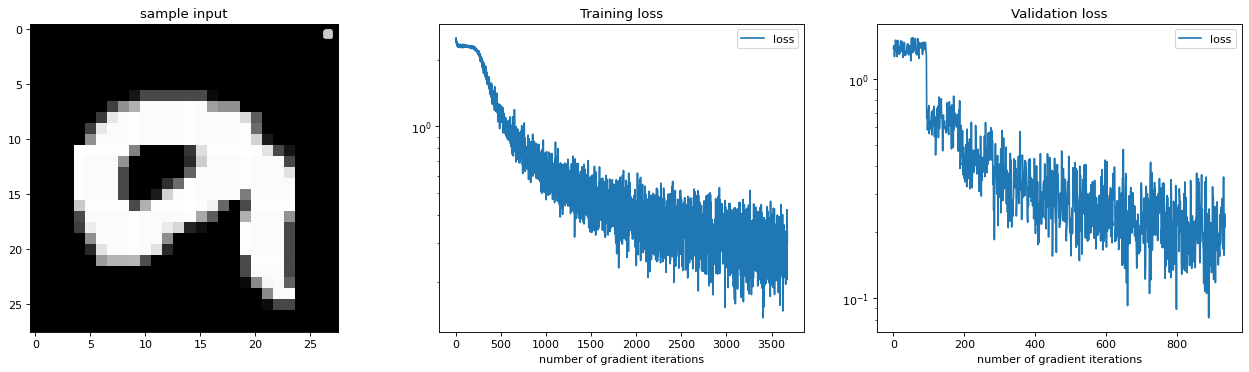

Validation epoch 9, iteration 90 of 94 (95 %), loss=0.2120


In [ ]:
# training loop
%matplotlib inline
from IPython import display

# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,3)

optimizer = torch.optim.Adam(network.parameters(), lr=0.0001)

num_epochs = 10
train_losses = []
val_losses = []

for e in range(num_epochs):
    train_iter = iter(train_loader)
    network.train()
    for i in range(len(train_loader)):        
        batch_cpu = next(train_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')        
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')
        
        # calculate the loss and backward the gradient
        loss = nn.CrossEntropyLoss()(pred['digit'], batch_gpu['digit'])        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())           

        if i%100==0:            
            axes[0].cla()
            axes[1].cla()            

            # plot some sample image inputs
            plot_images(batch_cpu['image'][0:1], ax=axes[0])    
            axes[0].legend()
            axes[0].set_title('sample input')

            # plot the training error on a log plot
            axes[1].plot(train_losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Training loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Training epoch {}, iteration {} of {} ({} %), loss={:0.4f}".format(e, i, len(train_loader), 100*i//len(train_loader), train_losses[-1]))            

    val_iter = iter(val_loader)
    network.eval()    
    for i in range(len(val_loader)):
        batch_cpu = next(val_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')
        
        # calculate the loss
        with torch.no_grad():
            loss = nn.CrossEntropyLoss()(pred['digit'], batch_gpu['digit'])        
            val_losses.append(loss.item()) 

        if i%10==0: 
            axes[2].cla()            

            # plot the validation error on a log plot
            axes[2].plot(val_losses, label='loss')
            axes[2].set_yscale('log')
            axes[2].set_title('Validation loss')
            axes[2].set_xlabel('number of gradient iterations')
            axes[2].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Validation epoch {}, iteration {} of {} ({} %), loss={:0.4f}".format(e, i, len(val_loader), 100*i//len(val_loader), val_losses[-1]))            
plt.close('all')

### Evaluation

#### Prediction Accuracy 

In [ ]:
def get_accuracy(network, data_loader):
    network.eval()
    iterator = iter(data_loader)    
    correct = 0
    total = 0
    for i in range(len(iterator)):        
        batch_cpu = next(iterator)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')        
        pred = network(batch_gpu)['digit'].argmax(dim=1, keepdim=True)                                        
        correct += pred.eq(batch_gpu['digit'].view_as(pred)).sum().item()        
        total += pred.shape[0]
           
    return correct / total

In [ ]:
# report accuracy on train, validation, and test sets
print('train acc:', get_accuracy(network, train_loader))
print('validation acc:', get_accuracy(network, val_loader))
print('test acc:', get_accuracy(network, test_loader))

train acc: 0.940125
validation acc: 0.935
test acc: 0.9429


#### Qualitative Results

predicted digits: [0 7 3 5 1 8]


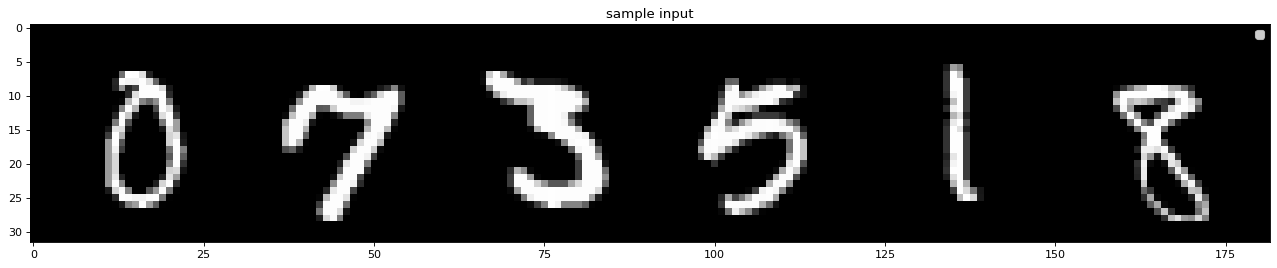

In [ ]:
# plot the input images and output of your network for a few samples in the test set

fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,1)

test_iter = iter(test_loader)
network.eval()    
for i in range(len(test_loader)):
    batch_cpu = next(test_iter)    
    axes.cla()        
    plot_images(batch_cpu['image'][0:6], ax=axes)
    axes.legend()
    axes.set_title('sample input')    
    
    batch_gpu = dict_to_device(batch_cpu, 'cuda')    
    pred = network(batch_gpu)

    pred_digits = pred['digit'].argmax(dim=1, keepdim=True)[0:6]
    pred_digits = pred_digits.cpu().numpy().flatten()
    print("predicted digits:", pred_digits)

    break